<a href="https://colab.research.google.com/github/fsternini/brats-task2/blob/development/brats_task2_launcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook setting

In [1]:
# First, verification of Python version is completed
!which python # should return /usr/local/bin/python
!python --version

/usr/local/bin/python
Python 3.10.12


In [2]:
# Google Drive is mounted, to reach all relevant data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/fsternini/brats-task2.git
%cd 'brats-task2'
# Switch to the most updated branch
!git switch development
# Collect the most updated version of the repo
!git pull

Cloning into 'brats-task2'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 128 (delta 54), reused 73 (delta 20), pack-reused 0
Receiving objects: 100% (128/128), 150.48 KiB | 1.07 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/brats-task2
Branch 'development' set up to track remote branch 'development' from 'origin'.
Switched to a new branch 'development'
Already up to date.


#Imports

In [4]:
# Install all requirements for the code
!pip install -r requirements.txt
#!pip install pydicom numpy torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [11]:
import os, sys
import json
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider, fixed
import pandas as pd

#Dataset reading

In [ ]:
import json

class Dataset:
    """Object representing the dataset"""

    def __init__(self, json_file):
        self.json_file = json_file
        try:
            with open(self.json_file, 'r') as self.json_file:
                self.dataset = json.load(self.json_file)
        except FileNotFoundError:
            print(f"The file '{self.json_file}' was not found.")
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
        except Exception as e:
            print(f"An error occurred: {e}")

    def get_files_in_node(self, node_name):
        files = []
        node = self.dataset
        def traverse(node):
                if isinstance(node, dict):
                    for key, value in node.items():
                        if key == node_name:
                            if isinstance(value, dict):
                                for sub_key, sub_value in value.items():
                                    if isinstance(sub_value, str):
                                        files.append(sub_value)
                                    else:
                                        traverse(sub_value)
                        else:
                            traverse(value)
                elif isinstance(node, list):
                    for item in node:
                        traverse(item)
        traverse(node)
        return files

ds = Dataset('/content/drive/MyDrive/Data Science/rsna-miccai-brain-tumor-radiogenomic-classification/datasetdataset_structure.json')

In [ ]:
class Volume:
    def __init__(self, dicom_dir):
        self.dicom_dir = dicom_dir
        self.volume_data = None

    def load_dicom_images(self):
        dicom_files = sorted([f for f in os.listdir(self.dicom_dir) if f.endswith('.dcm')])
        slices = [pydicom.dcmread(os.path.join(self.dicom_dir, f)) for f in dicom_files]
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))

        self.volume_data = np.stack([s.pixel_array for s in slices])

    def show_slice(self, slice_idx, index=0):
        ind = {
            0:self.volume_data[slice_idx, :, :],
            1:self.volume_data[:, slice_idx, :],
            2:self.volume_data[:, :, slice_idx]
        }
        plt.imshow(ind[index], cmap='gray')
        plt.axis('off')
        plt.show()

    def show_volume(self,index=0):
        self.slices = self.volume_data.shape[index]
        interact(self.show_slice, slice_idx=IntSlider(min=0, max=self.slices-1, step=1, value=0), index=fixed(index))


##EDA

In [ ]:
vol = Volume('/content/drive/MyDrive/Data Science/rsna-miccai-brain-tumor-radiogenomic-classification/dataset/train/00000/FLAIR')
vol.load_dicom_images()

In [ ]:
vol.show_volume(0)

interactive(children=(IntSlider(value=0, description='slice_idx', max=399), Output()), _dom_classes=('widget-i…

In [25]:
df = pd.read_csv('/content/drive/MyDrive/Data Science/rsna-miccai-brain-tumor-radiogenomic-classification/dataset/train_labels.csv')

In [ ]:
df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


###Orientation analysis

####Orientation extraction

In [22]:
try:
  with open('/content/drive/MyDrive/Data Science/rsna-miccai-brain-tumor-radiogenomic-classification/dataset/data.json','r') as file:
    data_dict = json.load(file)
except:
  data_dict = {}

In [23]:
def series_count(folder):
  s = set()
  p = folder
  for img in os.listdir(p):
    dcm = pydicom.dcmread(p+'/'+img)
    if dcm.SeriesInstanceUID not in s:
      s.add(dcm.SeriesInstanceUID)
  return len(s)
def orientation(folder):
  dcm = pydicom.dcmread(folder+'/'+os.listdir(folder)[0])

  return list(dcm.ImageOrientationPatient)

In [ ]:
for i in df["BraTS21ID"]:
  if i not in data_dict:
    temp_dict = {"id":i, "class": df.loc[df["BraTS21ID"] == i]["MGMT_value"].item()}
    dir_path = f"/content/drive/MyDrive/Data Science/rsna-miccai-brain-tumor-radiogenomic-classification/dataset/train/{i:05d}"
    temp_dict["data"]={}
    for dirname in os.listdir(dir_path):
      temp_dict["data"][dirname] = {
          "orientation": orientation(f"{dir_path}/{dirname}")
      }
    data_dict[i] = temp_dict
    with open('/content/drive/MyDrive/Data Science/rsna-miccai-brain-tumor-radiogenomic-classification/dataset/data.json', 'w') as outfile:
      json.dump(data_dict, outfile, indent=4)

####Analysis

In [27]:
df_data = pd.json_normalize(data_dict.values())

In [28]:
df_data.head()

,id,class,data.FLAIR.orientation,data.T1w.orientation,data.T1wCE.orientation,data.T2w.orientation
0,0,1,"[1.0, -0.0, 0.0, -0.0, -0.0, -1.0]","[1.0, -0.0, 0.0, -0.0, 1.0, 0.0]","[1.0, -0.0, 0.0, -0.0, -0.0, -1.0]","[-0.0, 1.0, 0.0, -0.0, -0.0, -1.0]"
1,2,1,"[-0.04540329, 0.99896874, 0.0, -0.0, -0.0, -1.0]","[0.999586, 0.0266035, 0.0109314, -0.0265941, 0...","[0.99942703, 0.033847, 0.0, -0.0, -0.0, -1.0]","[-0.0, 1.0, 0.0, -0.0, -0.0, -1.0]"
2,3,0,"[-0.00396099, 0.99816103, 0.06048864, 0.065223...","[0.995705, 0.091316, 0.015294, -0.0919349, 0.9...","[0.99963662, 0.02440997, 0.01143617, 0.0083274...","[0.0209028, 0.997263, 0.0709206, 0.0570101, 0...."
3,5,1,"[0.999933, 0.0115853, 0.0, 0.00121281, -0.1046...","[0.997774, 0.0247505, 0.0619187, -0.0169125, 0...","[0.99782761, 0.0567354, 0.03348367, 0.0382568,...","[-0.0425975, 0.994858, -0.091886, 0.0297932, -..."
4,6,1,"[0.9980977, -0.06165212, 3.88e-06, 0.06165186,...","[1.0, -0.0, 0.0, -0.0, 1.0, 0.0]","[1.0, -0.0, 0.0, -0.0, -0.0, -1.0]","[0.0596739, 0.998218, 0.0, -0.0, -0.0, -1.0]"


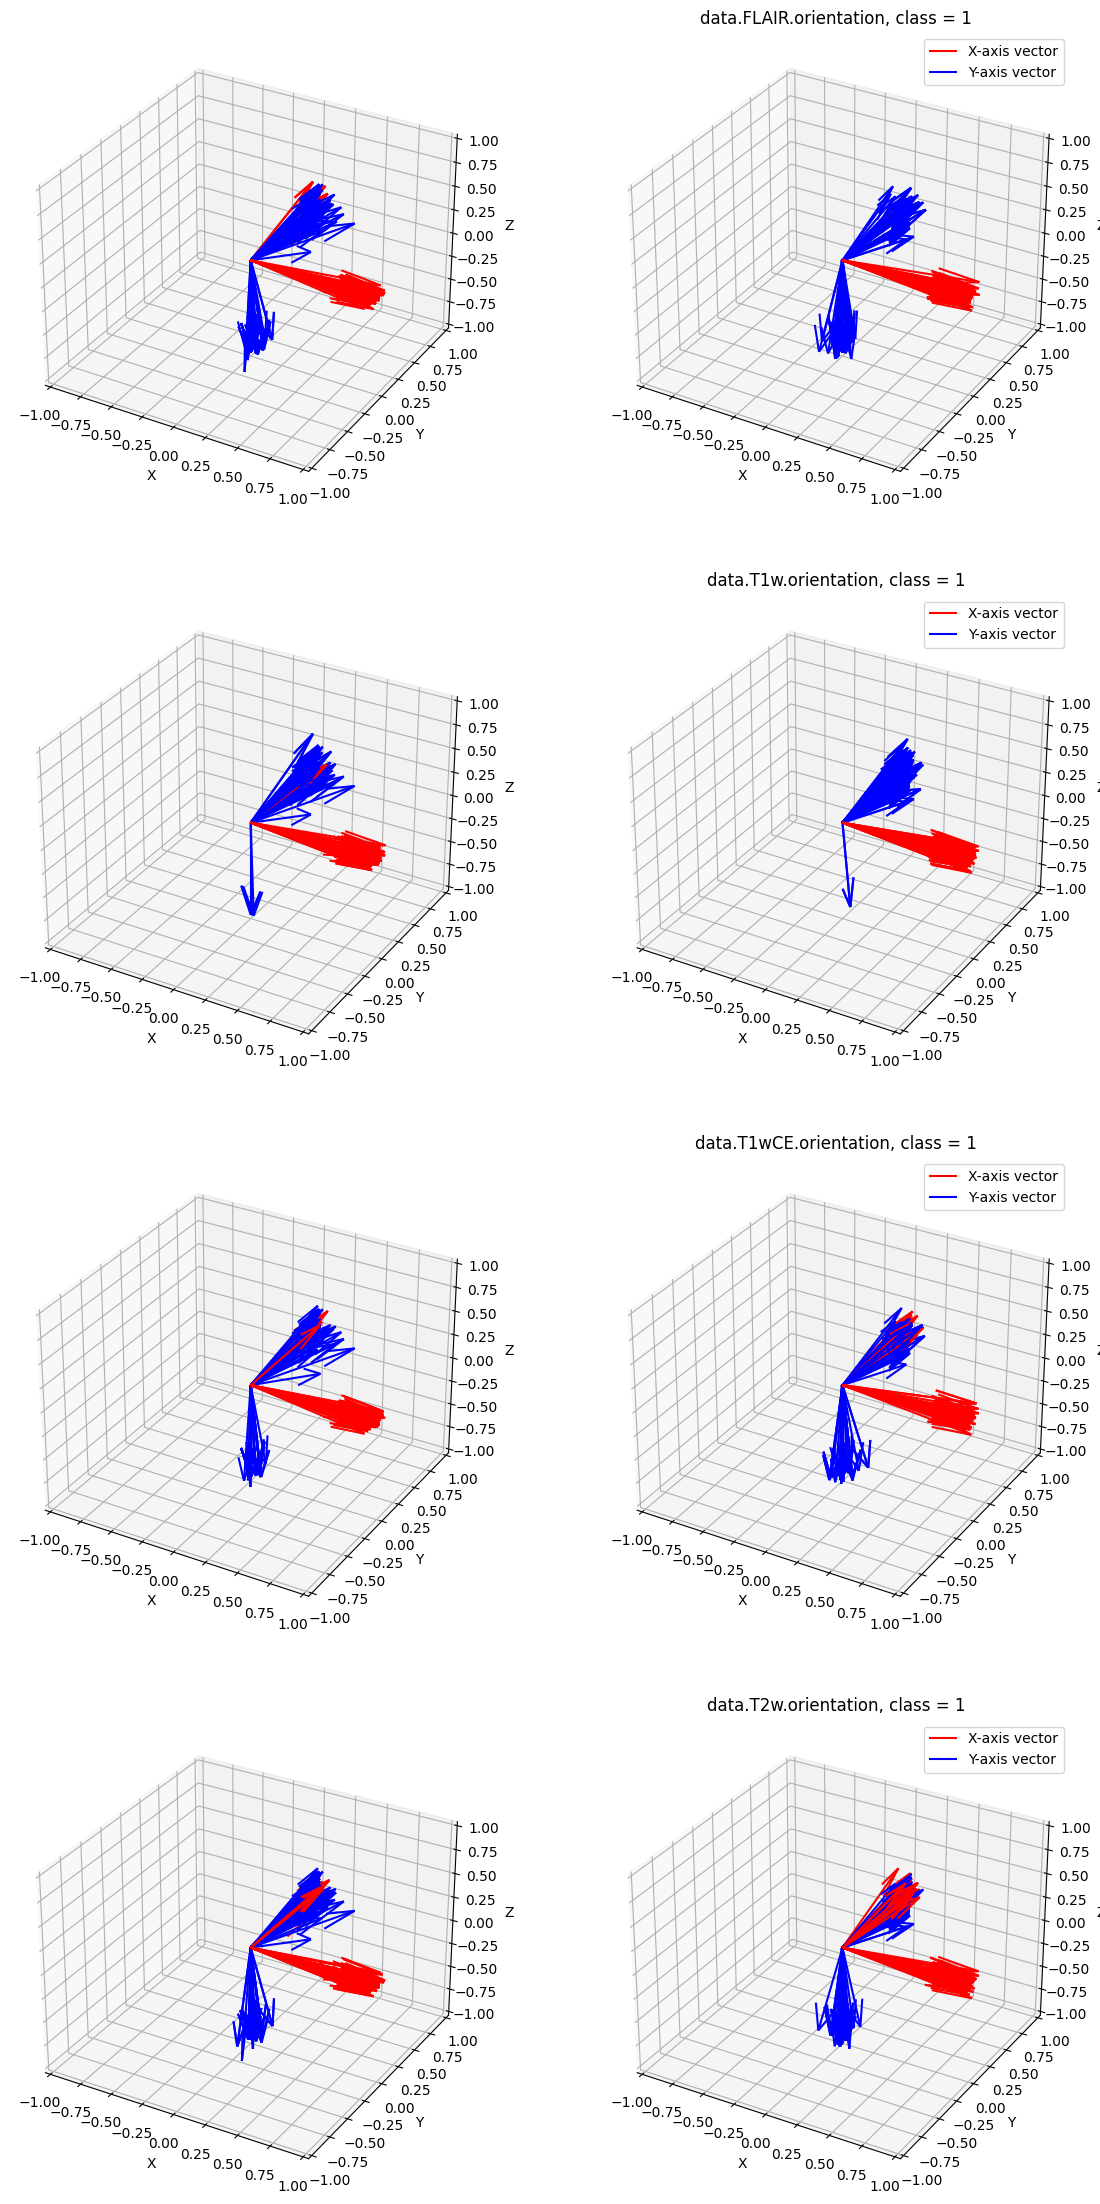

In [41]:
fig = plt.figure(figsize=(14,28))
images = ["data.FLAIR.orientation","data.T1w.orientation",
          "data.T1wCE.orientation","data.T2w.orientation"]
for i in range(len(images)):
  for j in [0,1]:
    pos = 421+2*i+j
    ax = fig.add_subplot(pos, projection='3d')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    for idx, row in df_data[df_data["class"]==j].iterrows():
        # Extracting the vectors
        x_vector = row[images[i]][:3]
        y_vector = row[images[i]][3:]

        # Plotting the x-vector
        ax.quiver(0, 0, 0, x_vector[0], x_vector[1], x_vector[2], color='r', label='X-axis vector' if idx == 0 else "")
        # Plotting the y-vector
        ax.quiver(0, 0, 0, y_vector[0], y_vector[1], y_vector[2], color='b', label='Y-axis vector' if idx == 0 else "")

    ax.legend()
    plt.title(f'{images[i]}, class = {j}')

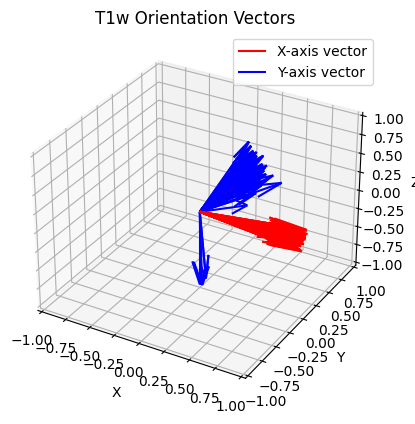

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for idx, row in df_data.iterrows():
    # Extracting the vectors
    x_vector = row['data.T1w.orientation'][:3]
    y_vector = row['data.T1w.orientation'][3:]

    # Plotting the x-vector
    ax.quiver(0, 0, 0, x_vector[0], x_vector[1], x_vector[2], color='r', label='X-axis vector' if idx == 0 else "")
    # Plotting the y-vector
    ax.quiver(0, 0, 0, y_vector[0], y_vector[1], y_vector[2], color='b', label='Y-axis vector' if idx == 0 else "")

ax.legend()
plt.title('T1w Orientation Vectors')
plt.show()

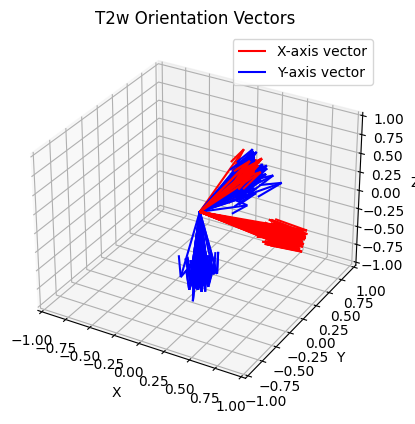

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for idx, row in df_data.iterrows():
    # Extracting the vectors
    x_vector = row['data.T2w.orientation'][:3]
    y_vector = row['data.T2w.orientation'][3:]

    # Plotting the x-vector
    ax.quiver(0, 0, 0, x_vector[0], x_vector[1], x_vector[2], color='r', label='X-axis vector' if idx == 0 else "")
    # Plotting the y-vector
    ax.quiver(0, 0, 0, y_vector[0], y_vector[1], y_vector[2], color='b', label='Y-axis vector' if idx == 0 else "")

ax.legend()
plt.title('T2w Orientation Vectors')
plt.show()

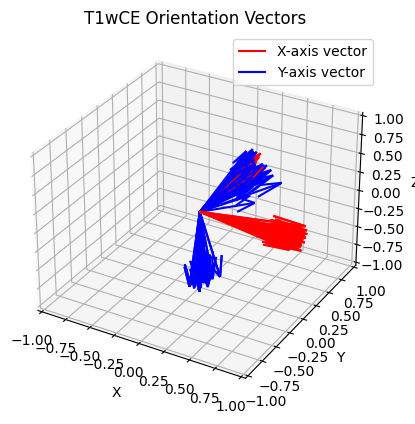

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for idx, row in df_data.iterrows():
    # Extracting the vectors
    x_vector = row['data.T1wCE.orientation'][:3]
    y_vector = row['data.T1wCE.orientation'][3:]

    # Plotting the x-vector
    ax.quiver(0, 0, 0, x_vector[0], x_vector[1], x_vector[2], color='r', label='X-axis vector' if idx == 0 else "")
    # Plotting the y-vector
    ax.quiver(0, 0, 0, y_vector[0], y_vector[1], y_vector[2], color='b', label='Y-axis vector' if idx == 0 else "")

ax.legend()
plt.title('T1wCE Orientation Vectors')
plt.show()